In [1]:
# !pip install cvxopt
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from cvxopt import matrix, solvers

In [2]:
rows = 10
cols = 10

# Q1) Creating reward functions and the heatmap

In [3]:
reward_function_1 = [[0.0 for x in range(cols)] for y in range(rows)]
reward_function_1[rows - 1][cols - 1] = 1.0
reward_function_1 = np.array(reward_function_1)

In [4]:
reward_function_2 = [[0.0 for x in range(cols)] for y in range(rows)]
reward_function_2 = np.array(reward_function_2)
reward_function_2[1:7,4] = -100.0
reward_function_2[1,5] = -100.0
reward_function_2[1:4,6] = -100.0
reward_function_2[7:9,6] = -100.0
reward_function_2[3,7] = -100.0
reward_function_2[7,7] = -100.0
reward_function_2[3:8,8] = -100.0
reward_function_2[9,9] = 10.0

In [5]:
np.random.seed(1234)

In [6]:

## Heatmap Function 
def heatmap(r, name):    
    plt.figure(figsize = (20,20))

    plt.imshow(r, vmin=-1, vmax=1)
    ax = plt.gca()
    plt.colorbar()
    #plt.title('Reward Function 1 heatmap', y=1.1)
    for y in range(10):
        for x in range(10):
            plt.text(x, y , '%.4f' % int(r[y, x]),
                     horizontalalignment='center',
                     verticalalignment='center', fontsize=15, color = 'w'
                     )
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(-0.5, 9, 1))
    ax.set_yticks(np.arange(-0.5, 9, 1))
    ax.set_xticklabels(np.arange(0, 10, 1))
    ax.set_yticklabels(np.arange(0, 10, 1))
    ax.grid(color='w', linestyle='-', linewidth=1)

    plt.text(0.5, 1.08, 'Heatmap for Reward Function - %s' %name,
             horizontalalignment='center',
             fontsize=40,
             transform = ax.transAxes)
    ax.xaxis.set_label_position('top')

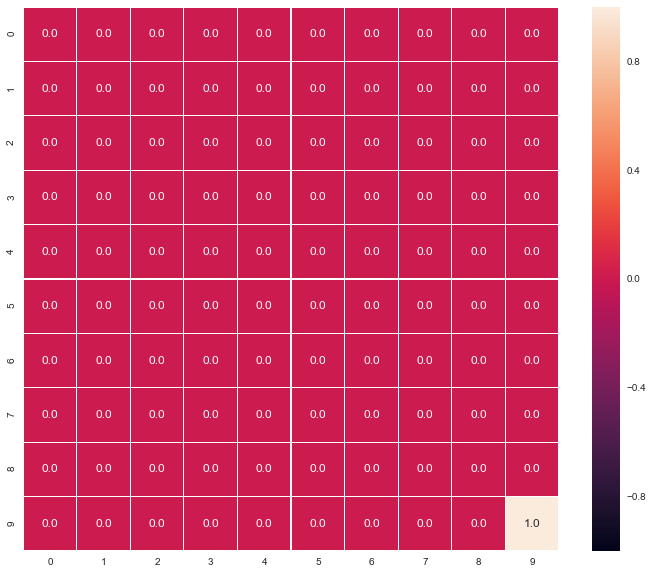

In [7]:
# heatmap(reward_function_1, '1')

import seaborn as sns; sns.set()
plt.figure(figsize = (12, 10))
sns.heatmap(reward_function_1, annot=reward_function_1, linewidths=0.1, fmt='', vmin=-1, vmax=1)


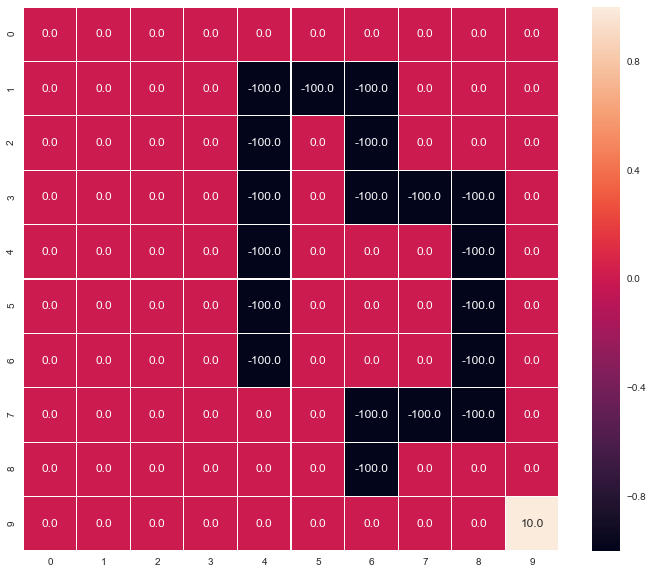

In [8]:
# heatmap(reward_function_2, '2')

plt.figure(figsize = (12, 10))
sns.heatmap(reward_function_2, annot=reward_function_2, linewidths=0.1, fmt='', vmin=-1, vmax=1)

# 2 Creating the environment for the agent

In [9]:
#Utility functions for the environment setup

def get_neighbors(state, rows, cols):
    left = state - rows
    
    right = state + rows
    
    #for states in last col
    if(right > rows*cols - 1):
        right = -1
    
    #for states in first row
    if(state % rows == 0):
        up = -1
    else:
        up = state - 1
    
    #for states in last row
    if(state % rows == rows -1):
        down = -1
    else:
        down = state + 1
    
    return {'L':left,'R':right,'U':up,'D': down}

def assign_prob(current_state, neighbors, action, wind_prob):

    current_state_prob = 0.0
    result_prob = {}
    for action_neigh in neighbors.keys():
        goto_state = neighbors[action_neigh]
        if(action_neigh == action):
            
            if(goto_state < 0):
                current_state_prob = current_state_prob + 1 - wind_prob + (wind_prob/4)
                result_prob[action_neigh] = 0.0
            else:
                result_prob[action_neigh] = 1 - wind_prob + (wind_prob/4)
        
        else:
            
            if(goto_state < 0):
                current_state_prob = current_state_prob + (wind_prob/4)
                result_prob[action_neigh] = 0.0
            else:
                result_prob[action_neigh] = wind_prob / 4
                
    result_prob['C'] = current_state_prob
    return result_prob
                

In [75]:
# #Value iteration algorithm
# def value_iteration_algo(num_states, action_set, transition_probabilities, 
#                          reward_function, estimation_epsilon, discount_factor):

#     #initialization
#     value_state = [0.0 for state in range(num_states)]

#     delta = math.inf
#     #Estimation
#     while(delta > estimation_epsilon):
#         delta = 0
#         for curr_state in range(num_states):

#             value = value_state[curr_state]
#             temp_value = -math.inf
#             for action in action_set:
#                 transition_vector = transition_probabilities[action][curr_state]
#                 reward_vector = reward_function
#                 temp_value = max(temp_value, 
#                                  value_iteration_comp(num_states,transition_vector, reward_vector, discount_factor, value_state))

#             value_state[curr_state] = temp_value
#             delta = max(delta, abs(value - value_state[curr_state]))

#     pi_state = [0.0 for state in range(num_states)]

#     #Computation
#     for curr_state in range(num_states):
#             temp_action = 'C'
#             temp_value = -math.inf
#             for action in action_set:
#                 transition_vector = transition_probabilities[action][curr_state]
#                 reward_vector = reward_function
#                 if value_iteration_comp(num_states,transition_vector, reward_vector, discount_factor, value_state) > temp_value:
#                     temp_action = action
#                     temp_value = value_iteration_comp(num_states,transition_vector, reward_vector, discount_factor, value_state)

#             pi_state[curr_state] = temp_action

#     #Return the optimal value policies and the actions
#     return [value_state, pi_state]

    
# #value iteration algo helper         
# def value_iteration_comp(num_states, transition_vector, reward_vector, discount_factor, value_state):
#     new_value_state = 0
    
#     for i in range(num_states):
#         new_value_state = new_value_state + (transition_vector[i] * (reward_vector[i] + (discount_factor * value_state[i])))
        
#     return new_value_state

In [80]:
#Value iteration algorithm
def value_iteration_algo(num_states, action_set, transition_probabilities, 
                         reward_function, estimation_epsilon, discount_factor):

    #initialization
    value_state = [0.0 for state in range(num_states)]
#     value_state_new = value_state
    value_state_new = [0.0 for state in range(num_states)]


    delta = math.inf
    #Estimation
    while(delta > estimation_epsilon):
        delta = 0
        for curr_state in range(num_states):

            value = value_state[curr_state]
            temp_value = -math.inf
            for action in action_set:
                transition_vector = transition_probabilities[action][curr_state]
                reward_vector = reward_function
                temp_value = max(temp_value, 
                                 value_iteration_comp(num_states,transition_vector, reward_vector, discount_factor, value_state))

            value_state_new[curr_state] = temp_value
            delta = max(delta, abs(value - value_state_new[curr_state]))
            
#         value_state = value_state_new
        for v_temp in range(len(value_state_new)):
            value_state[v_temp] = value_state_new[v_temp]

    pi_state = [0.0 for state in range(num_states)]

    #Computation
    for curr_state in range(num_states):
        temp_action = 'C'
        temp_value = -math.inf
        for action in action_set:
            transition_vector_ = transition_probabilities[action][curr_state]
            reward_vector = reward_function
            if value_iteration_comp(num_states,transition_vector_, reward_vector, discount_factor, value_state) > temp_value:
                if action == 'L' and pi_state[curr_state-10] == 'R':
                    continue
                elif action == 'U' and pi_state[curr_state-1] == 'D':
                    continue
                    
                elif curr_state % rows == 0 and action == 'U':
                    continue
                elif curr_state % rows == rows - 1 and action == 'D':
                    continue
                elif curr_state <= 9 and action == 'L':
                    continue
                elif curr_state >=90 and curr_state<99 and action == 'R':
                    continue
                temp_action = action
                temp_value = value_iteration_comp(num_states,transition_vector_, reward_vector, discount_factor, value_state)

        pi_state[curr_state] = temp_action

    #Return the optimal value policies and the actions
    return [value_state, pi_state]

    
#value iteration algo helper         
def value_iteration_comp(num_states, transition_vector, reward_vector, discount_factor, value_state):
    new_value_state = 0
    
    for i in range(num_states):
        new_value_state = new_value_state + (transition_vector[i] * (reward_vector[i] + (discount_factor * value_state[i])))
        
    return new_value_state



In [81]:
#Environment setup starts here:
grid_space = [[0.0 for x in range(cols)] for y in range(rows)]
for j in range(rows):
    for i in range(cols):
        grid_space[j][i] = i * 1.0 * rows + j

In [82]:
# Just a fun way to visualize the 100 states in a 10 X 10 grid
grid_space = np.array(grid_space)
#Total number of possible states
num_states = rows * cols  #100 for this case

#Total possible actions (up, left, Right, Down)
action_set = ['U','L','R','D']

#Number of actions
action_num = len(action_set)

#Wind probability w
wind_prob = 0.1

#Discount factor (gamma in the range [0,1) )
discount_factor = 0.8

#Setting up the transition matrix. We have a dictionary for the key being each action in our action set and the value
#being a 100 X 100 matrix denoting the probability of moving from any node i to j given that action
transition_probabilities = {}

for action in action_set:
    
    transition_matrix = [[0.0 for i in range(num_states)] for j in range(num_states)]
    
    for i in range(num_states):
        neighbors_i = get_neighbors(i, rows, cols)
        probs = assign_prob(current_state = i, neighbors = neighbors_i, action = action, wind_prob = wind_prob)
        for key in probs.keys():
            if(key == 'C'):
                transition_matrix[i][i] = probs[key]
            else:
                new_state = neighbors_i[key]
                if(new_state >= 0):
                    transition_matrix[i][new_state] = probs[key]
    
    transition_probabilities[action] = transition_matrix
        

In [83]:
#Reward function (in this case a vector as it depends only on end state) for this computation
reward_function = reward_function_1.flatten('F')
estimation_epsilon = 0.01
[value_state,pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              reward_function, estimation_epsilon, discount_factor)

# Result for q2, q3

In [84]:
optimal_value_state = np.asarray(value_state)
optimal_value_state = np.reshape(optimal_value_state, (rows,cols), order = 'F')

[[0.0442397  0.06457398 0.09118409 0.12504106 0.16807826 0.22269335
  0.29198796 0.37988042 0.49134892 0.61001145]
 [0.06457398 0.08833385 0.12185345 0.16476116 0.21945345 0.28917752
  0.37804302 0.49122817 0.63338372 0.78751905]
 [0.09118409 0.12185345 0.16458987 0.21930412 0.28906986 0.3779887
  0.49131731 0.63565109 0.81751608 1.01875794]
 [0.12504106 0.16476116 0.21930412 0.28906536 0.37798653 0.49132035
  0.63576137 0.81977022 1.05235181 1.31521922]
 [0.16807826 0.21945345 0.28906986 0.37798653 0.49132036 0.63576402
  0.81985582 1.05442573 1.35173221 1.69523349]
 [0.22269335 0.28917752 0.3779887  0.49132035 0.63576402 0.81985701
  1.05448231 1.35348475 1.73334073 2.18239181]
 [0.29198796 0.37804302 0.49131731 0.63576137 0.81985582 1.05448231
  1.3535115  1.73462151 2.21968743 2.80696303]
 [0.37988042 0.49122817 0.63565109 0.81977022 1.05442573 1.35348475
  1.73462151 2.22036214 2.83941767 3.60778693]
 [0.49134892 0.63338372 0.81751608 1.05235181 1.35173221 1.73334073
  2.21968743 

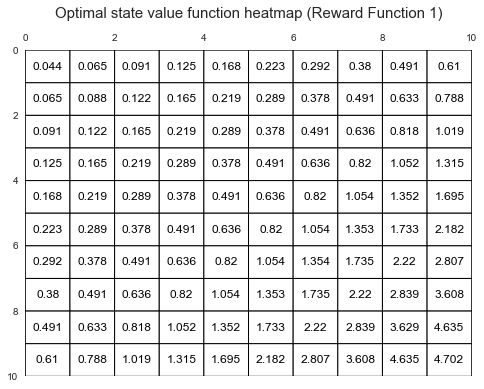

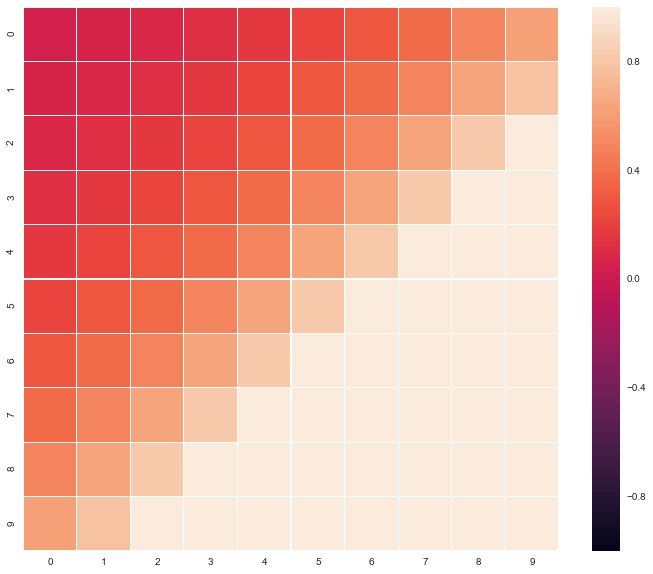

In [85]:
df = pd.DataFrame(optimal_value_state, columns = [i for i in range (cols)], index = [j for j in range(rows)])

#Plotting the optiaml value function
cmap = plt.cm.get_cmap(name = 'gray', lut = 1)
plt.figure(figsize = (8,6))
plt.pcolor(reward_function_2, cmap = cmap, edgecolor = 'k', linewidth = 1)
ax = plt.gca()

for i in range(10):
    for j in range(10):
        text = ax.text(j+0.5, i + 0.5, np.around(optimal_value_state[i][j], decimals = 3),
                  ha = 'center',va = 'center', size = 12, color="k")
plt.title('Optimal state value function plot (Reward Function 1)', y = 1.08, size = 15)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.xaxis.set_label_position('top')


print(optimal_value_state)

# #ASK HEATMAP
# #GENERATE HEATMAP
# plt.figure(figsize=(9,7))
# plt.pcolor(optimal_value_state, cmap = 'hot', linewidth = 1, edgecolor = 'b')
# ax = plt.gca()
# ax.invert_yaxis()
# plt.colorbar()
plt.title('Optimal state value function heatmap (Reward Function 1)', y = 1.08, size = 15)
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
plt.figure(figsize = (12, 10))
sns.heatmap(optimal_value_state, annot=False, linewidths=0.1, fmt='', vmin=-1, vmax=1)

# Do 4
# 5 result here

In [86]:
optimal_value_action = np.asarray(pi_state)

#Convert char to arrow
for i in range(len(optimal_value_action)):
    action = optimal_value_action[i]
    if action == 'U':
        optimal_value_action[i] = '↑'
    elif action == 'D':
        optimal_value_action[i] = '↓'
    elif action == 'R':
        optimal_value_action[i] = '→'
    elif action == 'L':
        optimal_value_action[i] = '←'
        
optimal_value_action = np.reshape(optimal_value_action, (rows,cols), order = 'F')

df = pd.DataFrame(optimal_value_action, columns = [i for i in range (cols)], index = [j for j in range(rows)])
df

#NEED TO PLOT OPTIMAL VALUE PROPERLY
#ASK HEATMAP
#GENERATE HEATMAP

,0,1,2,3,4,5,6,7,8,9
0,→,→,→,→,→,→,→,→,↓,↓
1,↓,→,→,→,→,→,↓,↓,↓,↓
2,↓,↓,→,→,→,↓,↓,↓,↓,↓
3,↓,↓,↓,→,↓,↓,↓,↓,↓,↓
4,↓,↓,↓,→,→,↓,↓,↓,↓,↓
5,↓,↓,→,→,→,↓,↓,↓,↓,↓
6,↓,→,→,→,→,→,→,↓,↓,↓
7,↓,→,→,→,→,→,→,↓,↓,↓
8,→,→,→,→,→,→,→,→,→,↓
9,→,→,→,→,→,→,→,→,→,→


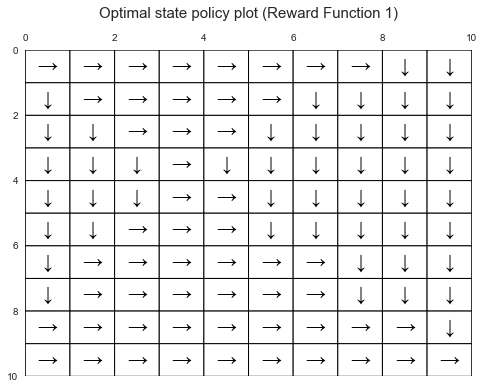

In [87]:
#Plotting the optiaml value function
cmap = plt.cm.get_cmap(name = 'gray', lut = 1)
plt.figure(figsize = (8,6))
plt.pcolor(reward_function_2, cmap = cmap, edgecolor = 'k', linewidth = 1)
ax = plt.gca()

for i in range(10):
    for j in range(10):
        text = ax.text(j+0.5, i + 0.5, optimal_value_action[i][j],
                  ha = 'center',va = 'center', size = 20, color="k")
plt.title('Optimal state policy plot (Reward Function 1)', y = 1.08, size = 15)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.xaxis.set_label_position('top')

In [88]:
#Reward function (in this case a vector as it depends only on end state) for this computation
reward_function = reward_function_2.flatten('F')
estimation_epsilon = 0.01
[value_state,pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              reward_function, estimation_epsilon, discount_factor)

# Result for q6,7

In [89]:
optimal_value_state = np.asarray(value_state)
optimal_value_state = np.reshape(optimal_value_state, (rows,cols), order = 'F')

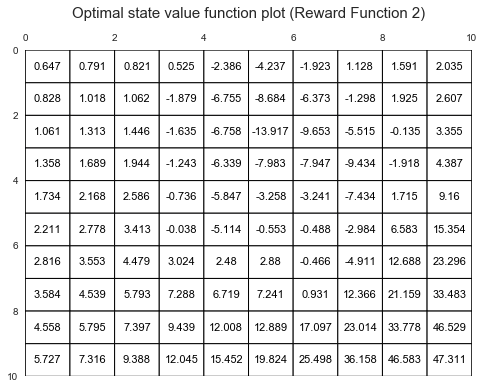

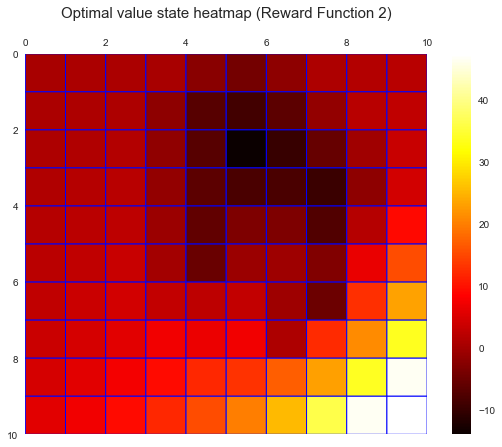

In [90]:
df = pd.DataFrame(optimal_value_state, columns = [i for i in range (cols)], index = [j for j in range(rows)])

#Plotting the optiaml value function
cmap = plt.cm.get_cmap(name = 'gray', lut = 1)
plt.figure(figsize = (8,6))
plt.pcolor(reward_function_2, cmap = cmap, edgecolor = 'k', linewidth = 1)
ax = plt.gca()

for i in range(10):
    for j in range(10):
        text = ax.text(j+0.5, i + 0.5, np.around(optimal_value_state[i][j], decimals = 3),
                  ha = 'center',va = 'center', size = 11, color="k")
plt.title('Optimal state value function plot (Reward Function 2)', y = 1.08, size = 15)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.xaxis.set_label_position('top')

#NEED TO PLOT OPTIMAL VALUE PROPERLY
#ASK HEATMAP
#GENERATE HEATMAP
plt.figure(figsize=(9,7))
plt.pcolor(optimal_value_state, cmap = 'hot', linewidth = 1, edgecolor = 'b')
ax = plt.gca()
ax.invert_yaxis()
plt.colorbar()
plt.title('Optimal value state heatmap (Reward Function 2)', y = 1.08, size = 15)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


In [91]:
optimal_value_action = np.asarray(pi_state)

#Convert char to arrow
for i in range(len(optimal_value_action)):
    action = optimal_value_action[i]
    if action == 'U':
        optimal_value_action[i] = '↑'
    elif action == 'D':
        optimal_value_action[i] = '↓'
    elif action == 'R':
        optimal_value_action[i] = '→'
    elif action == 'L':
        optimal_value_action[i] = '←'
        
optimal_value_action = np.reshape(optimal_value_action, (rows,cols), order = 'F')

df = pd.DataFrame(optimal_value_action, columns = [i for i in range (cols)], index = [j for j in range(rows)])
df

#NEED TO PLOT OPTIMAL VALUE PROPERLY
#ASK HEATMAP
#GENERATE HEATMAP


,0,1,2,3,4,5,6,7,8,9
0,↓,↓,↓,←,←,→,→,→,→,↓
1,↓,↓,↓,←,←,↑,→,→,→,↓
2,↓,↓,↓,←,←,↓,→,→,→,↓
3,↓,↓,↓,←,←,↓,↓,↑,→,↓
4,↓,↓,↓,←,←,↓,↓,↓,→,↓
5,↓,↓,↓,←,←,↓,↓,←,→,↓
6,↓,↓,↓,↓,↓,↓,←,←,→,↓
7,↓,↓,↓,↓,↓,↓,←,↓,↓,↓
8,→,→,→,↓,↓,↓,↓,↓,↓,↓
9,→,→,→,→,→,→,→,→,→,→


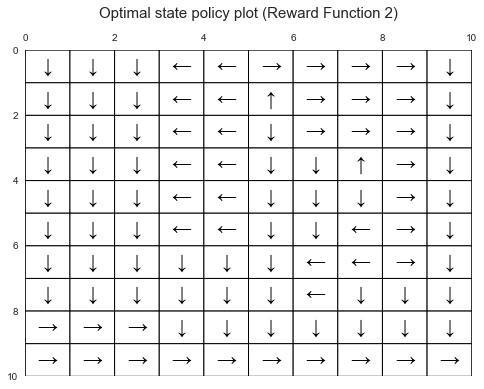

In [92]:
#Plotting the optimal value function
cmap = plt.cm.get_cmap(name = 'gray', lut = 1)
plt.figure(figsize = (8,6))
plt.pcolor(reward_function_2, cmap = cmap, edgecolor = 'k', linewidth = 1)
ax = plt.gca()

for i in range(10):
    for j in range(10):
        text = ax.text(j+0.5, i + 0.5, optimal_value_action[i][j],
                  ha = 'center',va = 'center', size = 20, color="k")
plt.title('Optimal state policy plot (Reward Function 2)', y = 1.08, size = 15)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.xaxis.set_label_position('top')

In [93]:
# ###################################################
# ##                                               ##
# ##           IRL FUNCTION                        ##
# ##                                               ##
# ###################################################


# def lp_irl(n_s, n_a, transition_probabilities, gamma, lambd, Rmax, policy):
    
#     c = -np.hstack([np.zeros(n_s), np.ones(n_s), -lambd*np.ones(n_s)]).reshape(3*n_s, 1)
#     c = matrix(c)
#     b = np.zeros([2*n_s*(n_a+1)])
    
#     b[2*n_s*(n_a-1): ] = Rmax
    
#     Z = np.zeros([2*(n_a+1)*n_s, 3*n_s])
    
#     for i in range(n_s):
#         a1 = policy[i]
#         inv = np.linalg.inv(np.identity(n_s) - gamma * np.array(transition_probabilities[a1]))
        
#         count = 0
#         for j in action_set:
#             if j != a1:
#                 Z[i * (n_a - 1) + count, :n_s] = -np.dot(np.array(transition_probabilities[a1][i]) - np.array(transition_probabilities[j][i]), inv)
#                 Z[n_s * (n_a - 1) + i * (n_a - 1) + count, :n_s]= -np.dot(np.array(transition_probabilities[a1][i]) - np.array(transition_probabilities[j][i]), inv)
#                 Z[n_s * (n_a - 1) + i * (n_a - 1) + count, n_s + i] = 1
#                 count += 1
                
                
#     for i in range(n_s):
#         Z[2 * n_s * (n_a - 1) + i, i] = -1
#         Z[2 * n_s * (n_a - 1) + n_s + i, i] = 1
#         Z[2 * n_s * (n_a - 1) + 2*n_s + i, i] = 1
#         Z[2 * n_s * (n_a - 1) + 3*n_s + i, i] = -1
        
#         Z[2 * n_s * (n_a - 1) + i, 2*n_s + i] = -1
#         Z[2 * n_s * (n_a - 1) + n_s + i, 2*n_s + i] = -1
        
#     A = matrix(Z)
#     b = matrix(b)
#     solvers.options['show_progress']=False


#     sol = solvers.lp(c, A, b)
#     return (sol['x'][:100])

In [94]:
def lp_irl(n_s, n_a, transition_probabilities, gamma, lambd, Rmax, policy):
    
    c = -np.hstack([np.zeros(n_s), np.ones(n_s), -lambd*np.ones(n_s)]).reshape(3*n_s, 1)
    c = matrix(c)
#     b = np.zeros([2*n_s*(n_a+1)])
    
#     b[2*n_s*(n_a-1): ] = Rmax
    
    Z = np.zeros([2*(n_a+1)*n_s, 3*n_s])
    b = np.zeros([2 * n_s * (n_a + 1)])
#     c = np.zeros([3 * n_s])

    
    for i in range(n_s):
        a1 = policy[i]
        inv = np.linalg.inv(np.identity(n_s) - gamma * np.array(transition_probabilities[a1]))
        
        count = 0
        for j in action_set:
            if j != a1:
                Z[i * (n_a - 1) + count, :n_s] = -np.dot(np.array(transition_probabilities[a1][i]) - np.array(transition_probabilities[j][i]), inv)
                Z[n_s * (n_a - 1) + i * (n_a - 1) + count, :n_s]= -np.dot(np.array(transition_probabilities[a1][i]) - np.array(transition_probabilities[j][i]), inv)
                Z[n_s * (n_a - 1) + i * (n_a - 1) + count, n_s + i] = 1
                count += 1
    
    for i in range(n_s):
        Z[2 * n_s * (n_a - 1) + i, i] = -1
        Z[2 * n_s * (n_a - 1) + i, 2*n_s + i] = -1
        
    for i in range(n_s):
        Z[2 * n_s * (n_a - 1) + n_s + i, i] = 1
        Z[2 * n_s * (n_a - 1) + n_s + i, 2*n_s + i] = -1
        
    for i in range(n_s):
        Z[2 * n_s * (n_a - 1) + 2*n_s + i, i] = 1
        b[2 * n_s * (n_a - 1) + 2*n_s + i] = Rmax
        
    for i in range(n_s):
        Z[2 * n_s * (n_a - 1) + 3*n_s + i, i] = -1
        b[2 * n_s * (n_a - 1) + 3*n_s + i] = Rmax
        
#     c = np.hstack([np.zeros(n_s), -np.ones(n_s), lambd*np.ones(n_s)]).reshape(3*n_s, 1)
#     print(c)
    
# # #     print(type(c))
#     c = matrix(c)
    
#     for i in range(n_s):
#         Z[2 * n_s * (n_a - 1) + i, i] = -1
#         Z[2 * n_s * (n_a - 1) + n_s + i, i] = 1
#         Z[2 * n_s * (n_a - 1) + 2*n_s + i, i] = 1
#         Z[2 * n_s * (n_a - 1) + 3*n_s + i, i] = -1
        
#         Z[2 * n_s * (n_a - 1) + i, 2*n_s + i] = -1
#         Z[2 * n_s * (n_a - 1) + n_s + i, 2*n_s + i] = -1
        
    A = matrix(Z)
    b = matrix(b)
    solvers.options['show_progress']=False


    sol = solvers.lp(c, A, b)
#     print(sol['x'])
    return (sol['x'][:100])

In [95]:
# def lp_irl(num_states, num_actions, prob_matrix, discount_factor, reg, Rmax, opt_policy):
#     c = np.zeros(3 * num_states)
#     c[num_states:2 * num_states] = -1
#     c[2 * num_states:3 * num_states ] = reg
    
#     h = np.zeros(2 * num_states * (num_actions - 1) + 4 * num_states)
#     h[2 * num_states * (num_actions - 1) + 2 * num_states:2 * num_states * (num_actions - 1) + 4 * num_states ]=Rmax
    
#     G = np.zeros([2 * num_states * (num_actions - 1) + 4 * num_states, 3 * num_states])
    
#     for i in range(num_states):
#         G[2 * num_states * (num_actions - 1) + 2 * num_states+i,i ]=1 #800-900
#         G[2 * num_states * (num_actions - 1) + 3 * num_states+i,i ]=-1 #900-1000
#         G[2 * num_states * (num_actions - 1) + i , i ]=1 #600-700, 1st col
#         G[2 * num_states * (num_actions - 1) + i , 2 * num_states+i ]=-1 #600-700, 3rd col
#         G[2 * num_states * (num_actions - 1) + num_states+i,i ]=-1 #700-800, 1st col
#         G[2 * num_states * (num_actions - 1) +num_states+ i,2 * num_states+i ]=-1 #700-800, 3rd col
    
#     for i in range(num_states):         ##first column for first 600 rows
#         a_i = opt_policy[i]
#         second_term = np.linalg.inv(np.identity(num_states) - discount_factor * np.array(prob_matrix[a_i]))

#         count = 0
#         for a in action_set:
#             if (a != a_i):
#                 G[i * (num_actions - 1) + count, :num_states] = -np.dot(np.array(prob_matrix[a_i][i]) - np.array(prob_matrix[a][i]), second_term)
            
#                 G[num_states * (num_actions - 1) + i * (num_actions - 1) + count, :num_states] = \
#                 -np.dot(np.array(prob_matrix[a_i][i]) - np.array(prob_matrix[a][i]), second_term)
                
#                 G[i * (num_actions - 1) + count, num_states + i] = 1
#                 count += 1
            
#     sol = solvers.lp(matrix(c), matrix(G), matrix(h))
#     return sol['x'][:100]

In [96]:
r = lp_irl(100, 4, transition_probabilities, 0.8, 0.5, 1, pi_state)

r = np.array(r)

r = r.reshape(10, 10)

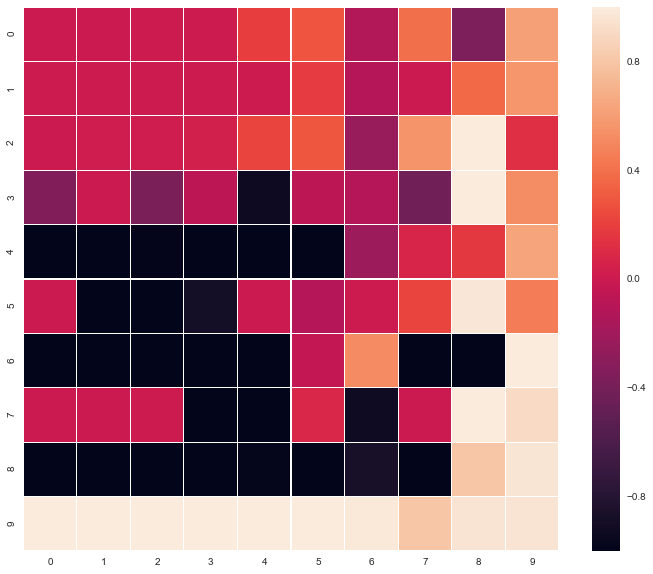

In [97]:
# plt.figure(figsize = (20,20))

# plt.imshow(r, cmap = 'jet')
# ax = plt.gca()
# plt.colorbar()
# #plt.title('Reward Function 1 heatmap', y=1.1)
# for y in range(10):
#     for x in range(10):
#         plt.text(x, y , '%.4f' % int(r[y, x]),
#                  horizontalalignment='center',
#                  verticalalignment='center', fontsize=15, color = 'w'
#                  )
# ax.xaxis.tick_top()
# ax.set_xticks(np.arange(-0.5, 9, 1))
# ax.set_yticks(np.arange(-0.5, 9, 1))
# ax.set_xticklabels(np.arange(0, 10, 1))
# ax.set_yticklabels(np.arange(0, 10, 1))
# ax.grid(color='w', linestyle='-', linewidth=1)

# # plt.text(0.5, 1.08, 'Heatmap for Reward Function 1',
#          horizontalalignment='center',
#          fontsize=40,
#          transform = ax.transAxes)
plt.figure(figsize = (12, 10))
sns.heatmap(r, annot=False, linewidths=0.1, fmt='', vmin=-1, vmax=1)

In [98]:
###################################################
##                                               ##
##    FUNCTION TO CALCULATE ACCURACY             ##
##                                               ##
###################################################

def comp(expert,agent):
  cnt=0
  for i in range(0,100):
    if (expert[i]==agent[i]):
      cnt=cnt+1
      
  accuracy= float(cnt)/100
  
  return accuracy

Expert policy: 
['R', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'D', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'R', 'R', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'R', 'R', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'R']
0.67
0.67
0.67
0.69
0.71
0.7
0.7
0.7
0.7
0.69
0.68
0.68
0.68
0.68
0.68
0.69
0.71
0.71
0.71
0.71
0.69
0.69
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.67
0.67
0.67
0.67
0.68
0.67
0.67
0.67
0.67
0.68
0.68
0.68
0.68
0.68
0.7
0.7
0.69
0.72
0.72
0.71
0.68
0.67
0.67
0.67
0.65
0.65
0.61
0.61
0.62
0.64
0.64
0.59
0.56
0.56
0.55
0.49
0.49
0.49
0.48
0.6
0.69
0.69
0.69
0.69
0.72
0.74
0.74
0.74
0.69
0.74
0.71
0.71
0.66
0.65
0.66
0.64
0.67
0.67
0.67
0.65
0.65
0.64
0.66
0.67
0.67
0.67
0.67


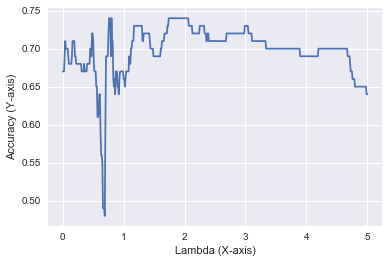

In [100]:
###################################################
##                                               ##
##                   Q11                         ##
##                                               ##
###################################################

#Calculate expert values
[expert_value_state,expert_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              reward_function_1.flatten('F'), estimation_epsilon, discount_factor)

print('Expert policy: ')
print(expert_pi_state)

#Compare expert values to 500 agent values
acc=[]

for i in range(0, 501):
    lam=i/100
    irl_new=lp_irl(100, 4, transition_probabilities, 0.8, lam, 1, expert_pi_state)
    [agent_value_state,agent_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                                irl_new, estimation_epsilon, discount_factor)
    acc.append(comp(expert_pi_state,agent_pi_state))
    print(comp(expert_pi_state,agent_pi_state))
  
    
lam_list=[]
for i in range(0, 501):
    lam=i/100
    lam_list.append(lam)

print('Agent policy: ')
print(acc)

#Plot acccuracy
plt.plot(lam_list,acc)
plt.xlabel('Lambda (X-axis)')
plt.ylabel('Accuracy (Y-axis)')
plt.show()

In [103]:
###################################################
##                                               ##
##                   Q12                         ##
##                                               ##
###################################################

#value 1 is equivalent to 0.1
print(np.argmax(acc))
print(acc[np.argmax(acc)])

lambda_max = np.argmax(acc)/100
print(lambda_max)

76
0.74
0.76


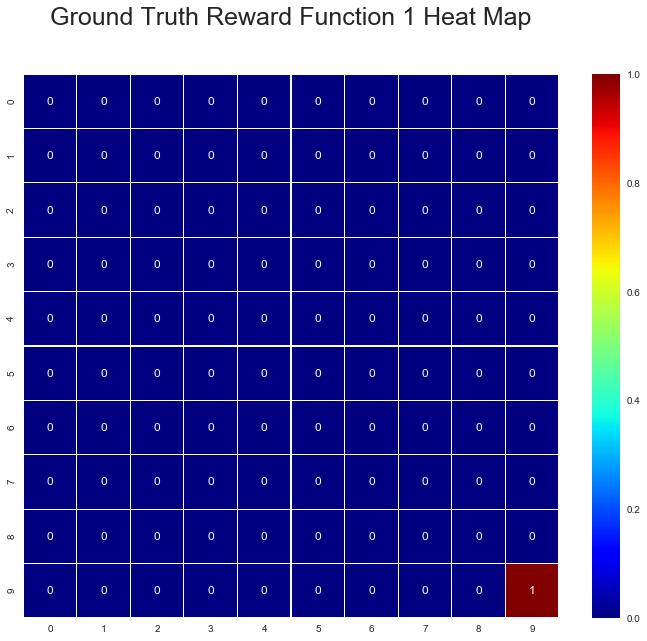

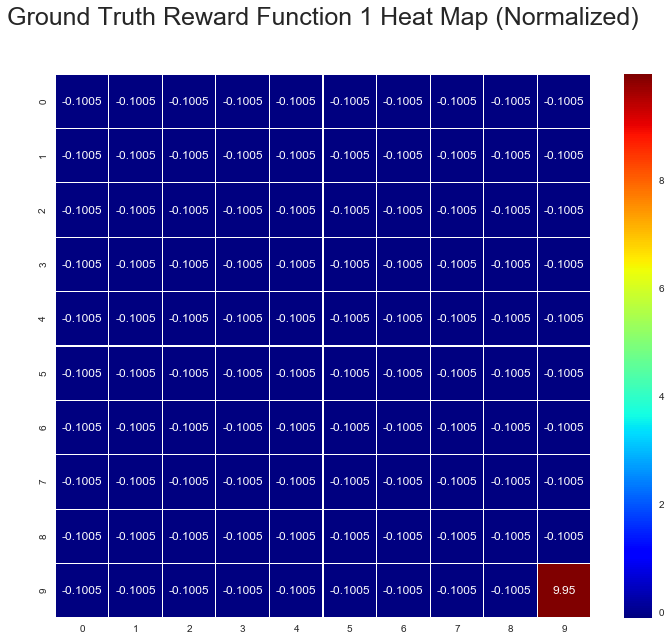

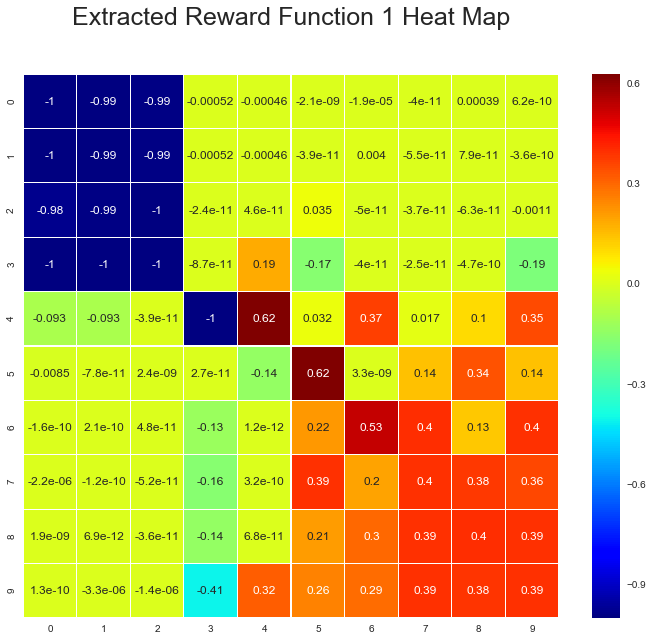

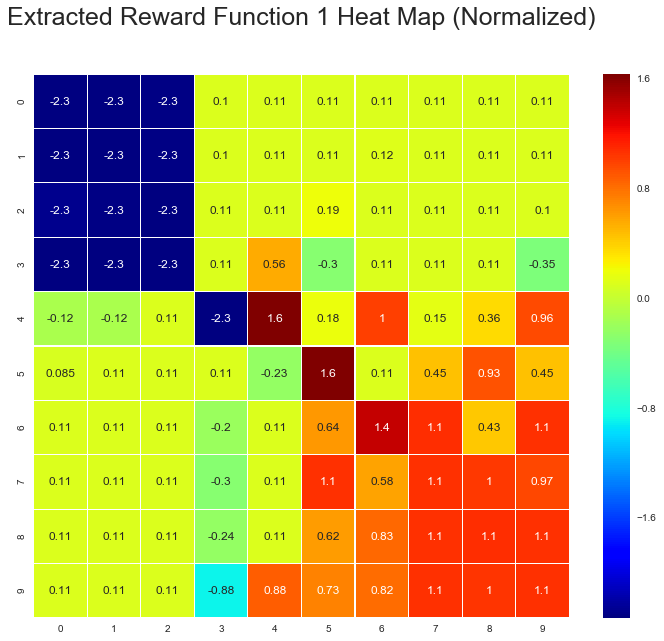

In [104]:
###################################################
##                                               ##
##                   Q13                         ##
##                                               ##
###################################################

#Ground Truth Reward Heat Map
# plt.figure(figsize=(9,7))
# plt.pcolor(reward_function_1, linewidth = 1.5, edgecolor = 'w',cmap = 'jet')
# ax = plt.gca()
# ax.invert_yaxis()
# plt.colorbar()
# fig, ax = plt.subplots(1, 2, figsize=(25, 10))
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
plt.figure(figsize = (12, 10))
plt.title('Ground Truth Reward Function 1 Heat Map', y = 1.08, size = 25)
sns.heatmap(reward_function_1, annot=reward_function_1, linewidths=0.1, vmin=np.min(reward_function_1), vmax=np.max(reward_function_1), cmap='jet')
plt.show()

plt.figure(figsize = (12, 10))
plt.title('Ground Truth Reward Function 1 Heat Map (Normalized)', y = 1.08, size = 25)
sns.heatmap((reward_function_1 - np.mean(reward_function_1))/np.std(reward_function_1), annot=True, linewidths=0.1, fmt='.4g', vmin=np.min((reward_function_1 - np.mean(reward_function_1))/np.std(reward_function_1)), vmax=np.max((reward_function_1 - np.mean(reward_function_1))/np.std(reward_function_1)), cmap='jet')
plt.show()



#Extracted Reward Heat Map
a=[]

temp_irl=lp_irl(100, 4, transition_probabilities, 0.8, lambda_max, 1, expert_pi_state)

a=temp_irl
a = np.array(a)
a = a.reshape(10, 10, order='F')

# plt.figure(figsize=(9,7))
# plt.pcolor(a, linewidth = 1.5, edgecolor = 'w',cmap = 'jet')
# ax = plt.gca()
# ax.invert_yaxis()
# plt.colorbar()
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
plt.figure(figsize = (12, 10))
plt.title('Extracted Reward Function 1 Heat Map', y = 1.08, size = 25)
sns.heatmap(a, annot=True, linewidths=0.1, vmin=np.min(a), vmax=np.max(a), cmap='jet')
plt.show()

plt.figure(figsize = (12, 10))
plt.title('Extracted Reward Function 1 Heat Map (Normalized)', y = 1.08, size = 25)
sns.heatmap((a-np.mean(a))/np.std(a), annot=True, linewidths=0.1, vmin=np.min((a-np.mean(a))/np.std(a)), vmax=np.max((a-np.mean(a))/np.std(a)), cmap='jet')
plt.show()

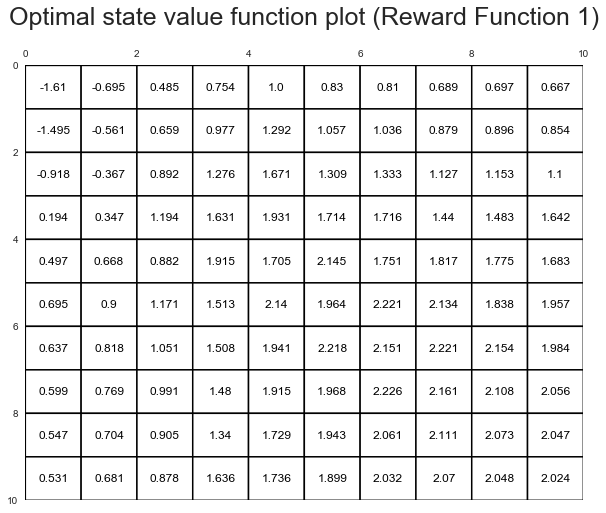

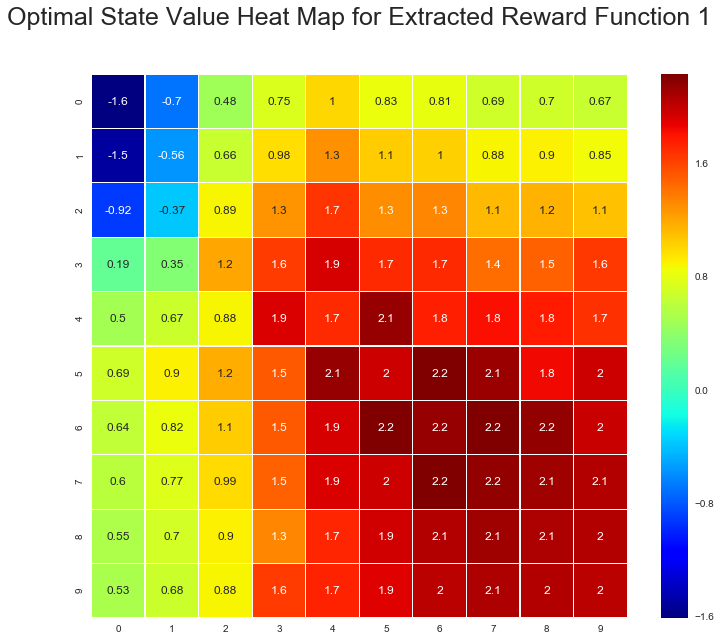

In [105]:
###################################################
##                                               ##
##                   Q14                         ##
##                                               ##
###################################################

temp_irl=lp_irl(100, 4, transition_probabilities, 0.8, lambda_max, 1, expert_pi_state)

[temp_agent_value_state,temp_agent_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              temp_irl, estimation_epsilon, discount_factor)

temp_optimal_value_state = np.asarray(temp_agent_value_state)
temp_optimal_value_state = np.reshape(temp_optimal_value_state, (rows,cols), order = 'F')


#Optimal Value plotting in 2D grid
#print(temp_optimal_value_state)
cmap = plt.cm.get_cmap(name = 'gray', lut = 1)
plt.figure(figsize = (10,8))
plt.pcolor(reward_function_1, cmap = cmap, edgecolor = 'k', linewidth = 1.5)
ax = plt.gca()

for i in range(10):
    for j in range(10):
        text = ax.text(j+0.5, i + 0.5, np.around(temp_optimal_value_state[i][j], decimals = 3),
                  ha = 'center',va = 'center', size = 12, color="k")
plt.title('Optimal state value function plot (Reward Function 1)', y = 1.08, size = 25)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.xaxis.set_label_position('top')



#Heat Map
# plt.figure(figsize=(9,7))
# plt.pcolor(temp_optimal_value_state, linewidth = 1.5, edgecolor = 'w',cmap = 'jet')
# ax = plt.gca()
# ax.invert_yaxis()
# plt.colorbar()
# plt.title('Optimal State Value Heat Map for Extracted Reward Function 1', y = 1.08, size = 15)
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')

plt.figure(figsize = (12, 10))
plt.title('Optimal State Value Heat Map for Extracted Reward Function 1', y = 1.08, size = 25)
sns.heatmap(temp_optimal_value_state, annot=True, linewidths=0.1, vmin=np.min(temp_optimal_value_state), vmax=np.max(temp_optimal_value_state), cmap='jet')
plt.show()

In [106]:
###################################################
##                                               ##
##                   Q16                         ##
##                                               ##
###################################################

temp_irl=lp_irl(100, 4, transition_probabilities, 0.8, lambda_max, 1, expert_pi_state)

[temp_agent_value_state,temp_agent_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              temp_irl, estimation_epsilon, discount_factor)

optimal_value_action = np.asarray(temp_agent_pi_state)

#Convert char to arrow
for i in range(len(optimal_value_action)):
    action = optimal_value_action[i]
    if action == 'U':
        optimal_value_action[i] = '↑'
    elif action == 'D':
        optimal_value_action[i] = '↓'
    elif action == 'R':
        optimal_value_action[i] = '→'
    elif action == 'L':
        optimal_value_action[i] = '←'
        
optimal_value_action = np.reshape(optimal_value_action, (rows,cols), order = 'F')

df = pd.DataFrame(optimal_value_action, columns = [i for i in range (cols)], index = [j for j in range(rows)])
df

# plt.figure(figsize = (12, 10))
# # plt.title('Optimal State Value Heat Map for Extracted Reward Function 1', y = 1.08, size = 25)
# sns.heatmap(temp_optimal_value_state, annot=optimal_value_action, fmt='',  linewidths=0.1, vmin=-1, vmax=1)
# plt.show()

,0,1,2,3,4,5,6,7,8,9
0,→,→,→,→,↓,↓,↓,↓,↓,↓
1,→,→,→,→,↓,↓,↓,↓,↓,↓
2,↓,→,→,→,↓,←,↓,↓,↓,↓
3,↓,↓,→,→,↓,↓,↓,↓,↓,↓
4,↓,↓,↓,→,→,↓,↓,↓,↓,↓
5,→,→,→,→,→,↓,↓,↓,↓,↓
6,→,→,→,→,→,→,→,↓,←,↓
7,→,→,→,→,→,↑,↑,↓,←,←
8,→,→,→,→,→,↑,→,→,↑,←
9,→,→,→,→,→,→,→,↑,↑,↑


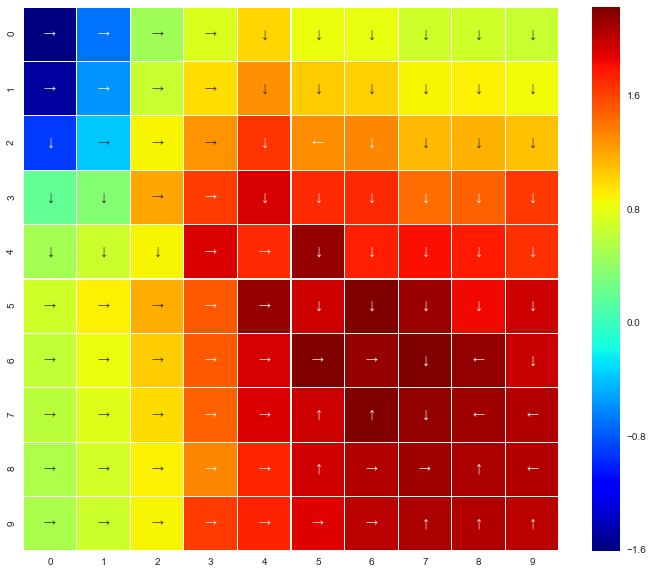

In [107]:
plt.figure(figsize = (12, 10))
# plt.title('Optimal State Value Heat Map for Extracted Reward Function 1', y = 1.08, size = 25)
sns.heatmap(temp_optimal_value_state, annot=optimal_value_action, fmt='',  linewidths=0.1, vmin=np.min(temp_optimal_value_state), vmax=np.max(temp_optimal_value_state), cmap='jet')
plt.show()

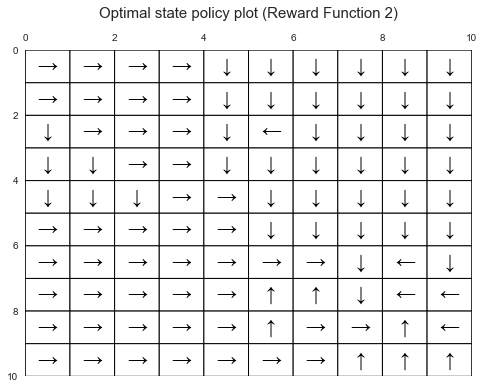

In [108]:
cmap = plt.cm.get_cmap(name = 'gray', lut = 1)
plt.figure(figsize = (8,6))
plt.pcolor(reward_function_2, cmap = cmap, edgecolor = 'k', linewidth = 1)
ax = plt.gca()

for i in range(10):
    for j in range(10):
        text = ax.text(j+0.5, i + 0.5, optimal_value_action[i][j],
                  ha = 'center',va = 'center', size = 20, color="k")
plt.title('Optimal state policy plot (Reward Function 2)', y = 1.08, size = 15)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.xaxis.set_label_position('top')

0.0 0.75
0.01 0.75
0.02 0.75
0.03 0.75
0.04 0.77
0.05 0.77
0.06 0.76
0.07 0.76
0.08 0.77
0.09 0.78
0.1 0.78
0.11 0.78
0.12 0.78
0.13 0.78
0.14 0.78
0.15 0.8
0.16 0.83
0.17 0.82
0.18 0.82
0.19 0.82
0.2 0.83
0.21 0.83
0.22 0.82
0.23 0.8
0.24 0.8
0.25 0.81
0.26 0.81
0.27 0.81
0.28 0.81
0.29 0.81
0.3 0.81
0.31 0.81
0.32 0.81
0.33 0.81
0.34 0.81
0.35 0.81
0.36 0.81
0.37 0.81
0.38 0.82
0.39 0.82
0.4 0.82
0.41 0.82
0.42 0.82
0.43 0.81
0.44 0.81
0.45 0.8
0.46 0.78
0.47 0.78
0.48 0.79
0.49 0.79
0.5 0.8
0.51 0.81
0.52 0.81
0.53 0.81
0.54 0.8
0.55 0.82
0.56 0.83
0.57 0.83
0.58 0.83
0.59 0.82
0.6 0.82
0.61 0.82
0.62 0.82
0.63 0.81
0.64 0.81
0.65 0.81
0.66 0.81
0.67 0.81
0.68 0.81
0.69 0.81
0.7 0.8
0.71 0.8
0.72 0.81
0.73 0.79
0.74 0.8
0.75 0.8
0.76 0.81
0.77 0.81
0.78 0.81
0.79 0.79
0.8 0.79
0.81 0.79
0.82 0.79
0.83 0.79
0.84 0.78
0.85 0.78
0.86 0.77
0.87 0.77
0.88 0.77
0.89 0.77
0.9 0.77
0.91 0.77
0.92 0.75
0.93 0.75
0.94 0.75
0.95 0.75
0.96 0.76
0.97 0.76
0.98 0.76
0.99 0.75
1.0 0.75
1.01 0.75
1

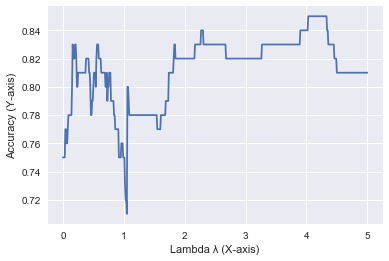

In [109]:
###################################################
##                                               ##
##                   Q17                         ##
##                                               ##
###################################################

#Calculate expert values
[expert_value_state,expert_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              reward_function_2.flatten('F'), estimation_epsilon, discount_factor)


#Compare expert values to 500 agent values
acc=[]

for i in range(0, 501):
  lam=i/100
  irl_new=lp_irl(100, 4, transition_probabilities, 0.8, lam, 10, expert_pi_state)
  temp_stuff = []
  for tttt in irl_new:
    temp_stuff.append(tttt)
  [agent_value_state,agent_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              temp_stuff, estimation_epsilon, discount_factor)
  acc.append(comp(expert_pi_state,agent_pi_state))
  print(lam, comp(expert_pi_state,agent_pi_state))
  
lam_list=[]
for i in range(0, 501):
  lam=i/100
  lam_list.append(lam)
  
#Plot acccuracy
plt.plot(lam_list,acc)
plt.xlabel('Lambda λ (X-axis)')
plt.ylabel('Accuracy (Y-axis)')
plt.show()

In [110]:
###################################################
##                                               ##
##                   Q18                         ##
##                                               ##
###################################################

#value 1 is equivalent to 0.1
print(np.argmax(acc))
print(acc[np.argmax(acc)])
lambda_max_2 = np.argmax(acc)/100
print(lambda_max_2)

403
0.85
4.03


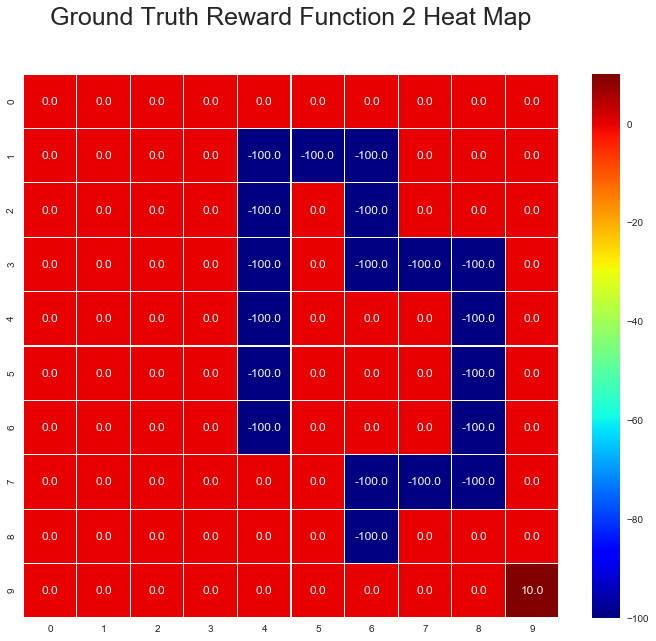

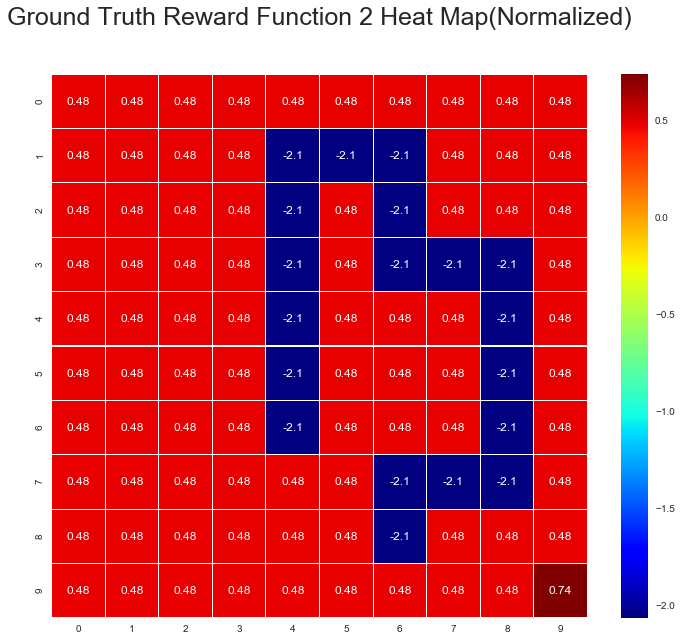

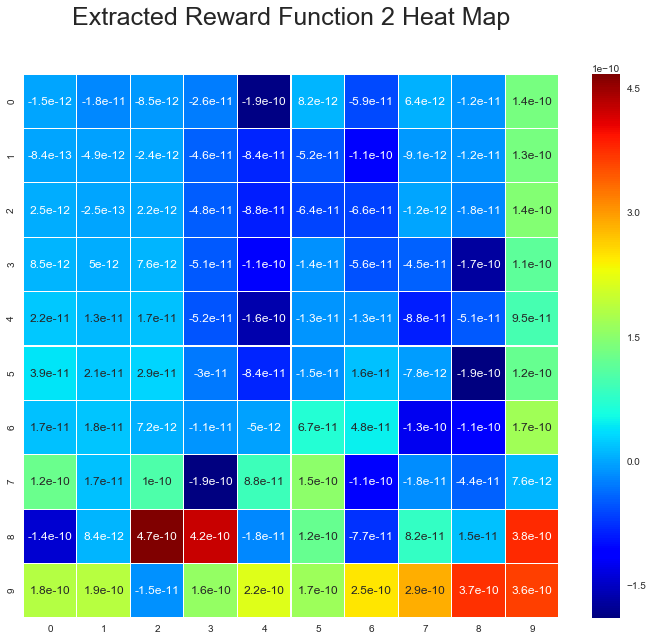

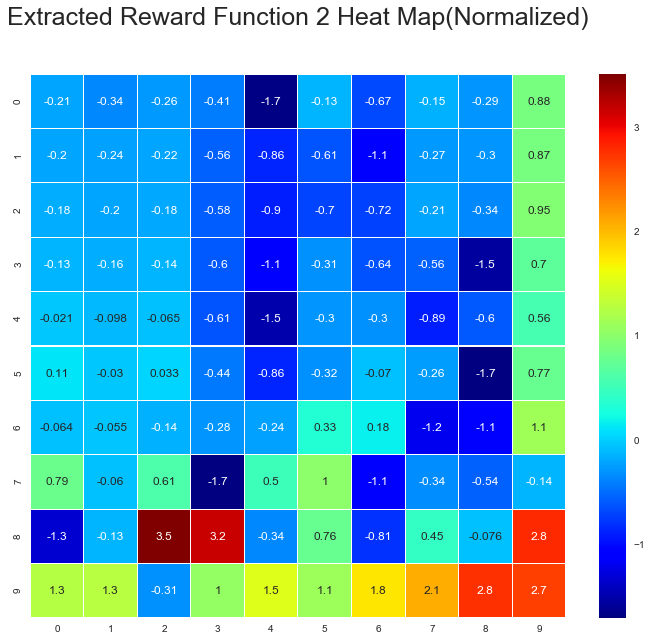

In [111]:
###################################################
##                                               ##
##                   Q19                         ##
##                                               ##
###################################################

#Ground Truth Reward Heat Map
# plt.figure(figsize=(9,7))
# plt.pcolor(reward_function_2, linewidth = 1.5, edgecolor = 'w',cmap = 'jet')
# ax = plt.gca()
# ax.invert_yaxis()
# plt.colorbar()
# plt.title('Ground Truth Reward Function 2 Heat Map', y = 1.08, size = 15)
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')

plt.figure(figsize = (12, 10))
plt.title('Ground Truth Reward Function 2 Heat Map', y = 1.08, size = 25)
sns.heatmap(reward_function_2, annot=reward_function_2, fmt='',  linewidths=0.1, vmin=np.min(reward_function_2), vmax=np.max(reward_function_2), cmap='jet')
plt.show()

plt.figure(figsize = (12, 10))
plt.title('Ground Truth Reward Function 2 Heat Map(Normalized)', y = 1.08, size = 25)
sns.heatmap((reward_function_2 - np.mean(reward_function_2))/np.std(reward_function_2), annot=True,  linewidths=0.1, vmin=np.min((reward_function_2 - np.mean(reward_function_2))/np.std(reward_function_2)), vmax=np.max((reward_function_2 - np.mean(reward_function_2))/np.std(reward_function_2)), cmap='jet')
plt.show()


#Extracted Reward Heat Map
a=[]

temp_irl=lp_irl(100, 4, transition_probabilities, 0.8, lambda_max_2, 10, expert_pi_state)

a=temp_irl
a = np.array(a)
a = a.reshape(10, 10, order='F')

# plt.figure(figsize=(9,7))
# plt.pcolor(a, linewidth = 1.5, edgecolor = 'w',cmap = 'jet')
# ax = plt.gca()
# ax.invert_yaxis()
# plt.colorbar()
# plt.title('Extracted Reward Function 2 Heat Map', y = 1.08, size = 15)
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')

plt.figure(figsize = (12, 10))
plt.title('Extracted Reward Function 2 Heat Map', y = 1.08, size = 25)
sns.heatmap(a, annot=True,  linewidths=0.1, vmin=np.min(a), vmax=np.max(a), cmap='jet')
plt.show()

plt.figure(figsize = (12, 10))
plt.title('Extracted Reward Function 2 Heat Map(Normalized)', y = 1.08, size = 25)
sns.heatmap((a-np.mean(a))/np.std(a), annot=True,  linewidths=0.1, vmin=np.min((a-np.mean(a))/np.std(a)), vmax=np.max((a-np.mean(a))/np.std(a)), cmap='jet')
plt.show()

[[-1.75157796e-12 -2.55222872e-12 -4.12340002e-12 -1.51584617e-11
  -6.98206078e-13 -7.25174813e-13  2.61581346e-12  3.85498364e-12
   1.21384978e-10  1.28111279e-10]
 [ 1.89773672e-12 -1.04534475e-12  3.53183297e-13 -6.75581245e-12
  -5.20926452e-11  2.34405779e-13 -1.38819815e-11  2.84894756e-12
   1.19676137e-10  1.35413776e-10]
 [ 7.91750963e-12  4.68240071e-12  5.90326251e-12 -2.81428580e-12
  -5.24082163e-11 -1.94123403e-11 -6.78596773e-12 -1.26862019e-11
   1.24739288e-10  1.34712098e-10]
 [ 2.09968602e-11  1.23753059e-11  1.46896378e-11  1.82448893e-12
  -2.16922530e-11 -1.90363785e-11 -1.70366487e-11 -8.72330972e-12
   9.84343163e-11  1.30150232e-10]
 [ 3.73126487e-11  2.16881596e-11  2.65985493e-11  9.74335740e-12
  -1.94377119e-11 -1.85733267e-11  1.15775525e-11 -1.11382283e-11
   7.47738593e-11  1.13553183e-10]
 [ 3.77376291e-11  3.77525382e-11  1.96216314e-11  2.36733534e-11
  -1.01742394e-11  5.91177689e-11  4.25985557e-11  5.71901759e-12
   1.05658160e-10  1.49325241e-10

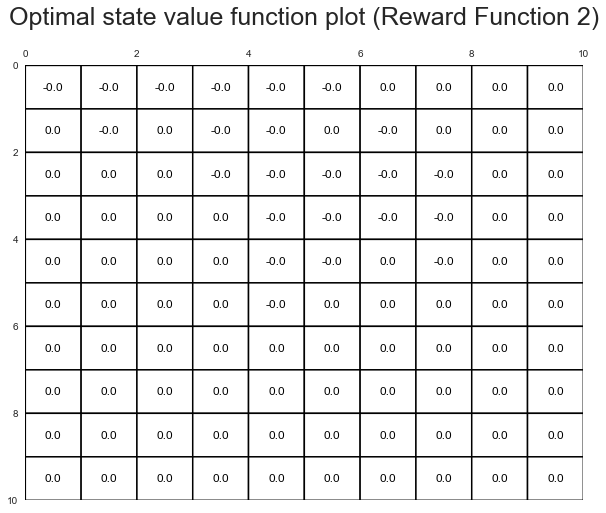

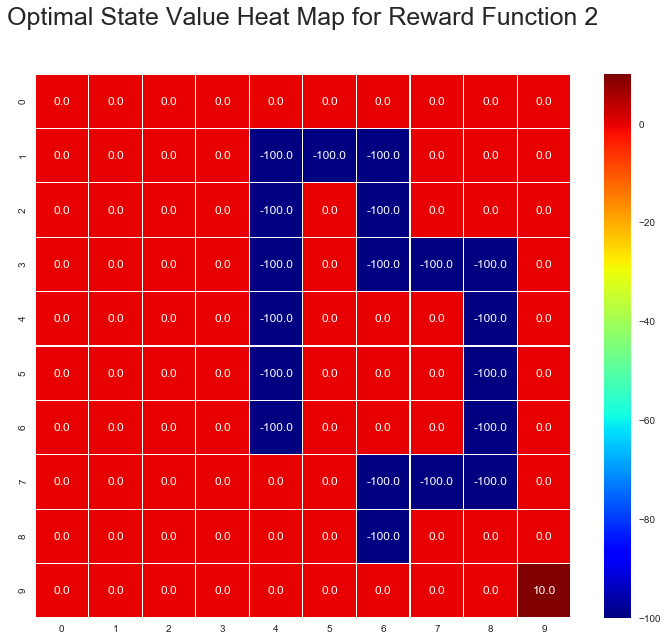

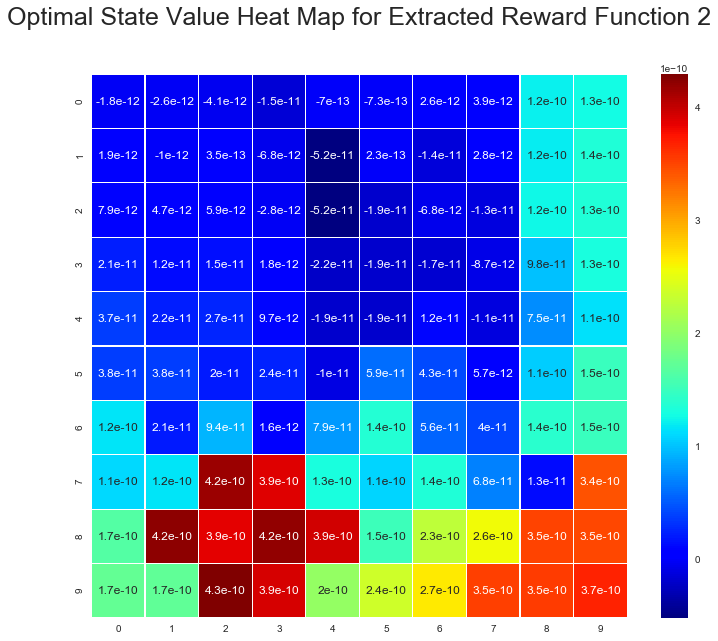

In [46]:
###################################################
##                                               ##
##                   Q20                         ##
##                                               ##
###################################################

# temp_irl=lp_irl(100, 4, transition_probabilities, 0.8, lambda_max_2, 10, expert_pi_state)

# [temp_agent_value_state,temp_agent_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
#                                               temp_irl, estimation_epsilon, discount_factor)

# temp_optimal_value_state = np.asarray(temp_agent_value_state)
# temp_optimal_value_state = np.reshape(temp_optimal_value_state, (rows,cols), order = 'F')


# #Optimal Value plotting in 2D grid
# #print(temp_optimal_value_state)
# cmap = plt.cm.get_cmap(name = 'gray', lut = 1)
# plt.figure(figsize = (10,8))
# plt.pcolor(reward_function_2, cmap = cmap, edgecolor = 'k', linewidth = 1.5)
# ax = plt.gca()

# for i in range(10):
#     for j in range(10):
#         text = ax.text(j+0.5, i + 0.5, np.around(temp_optimal_value_state[i][j], decimals = 4),
#                   ha = 'center',va = 'center', size = 12, color="k")
# plt.title('Optimal state value function plot (Reward Function 2)', y = 1.08, size = 25)
# ax.xaxis.tick_top()
# ax.invert_yaxis()
# ax.xaxis.set_label_position('top')

temp_irl=lp_irl(100, 4, transition_probabilities, 0.8, lambda_max_2, 10, expert_pi_state)

[temp_agent_value_state,temp_agent_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              temp_irl, estimation_epsilon, discount_factor)

temp_optimal_value_state = np.asarray(temp_agent_value_state)
temp_optimal_value_state = np.reshape(temp_optimal_value_state, (rows,cols), order = 'F')


#Optimal Value plotting in 2D grid
#print(temp_optimal_value_state)
cmap = plt.cm.get_cmap(name = 'gray', lut = 1)
plt.figure(figsize = (10,8))
plt.pcolor(reward_function_2, cmap = cmap, edgecolor = 'k', linewidth = 1.5)
ax = plt.gca()

for i in range(10):
    for j in range(10):
        text = ax.text(j+0.5, i + 0.5, np.around(temp_optimal_value_state[i][j], decimals = 8),
                  ha = 'center',va = 'center', size = 12, color="k")
plt.title('Optimal state value function plot (Reward Function 2)', y = 1.08, size = 25)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.xaxis.set_label_position('top')

print(temp_optimal_value_state)




#Heat Map
# plt.figure(figsize=(9,7))
# plt.pcolor(temp_optimal_value_state, linewidth = 1.5, edgecolor = 'w',cmap = 'jet')
# ax = plt.gca()
# ax.invert_yaxis()
# plt.colorbar()
# plt.title('Optimal State Value Heat Map for Extracted Reward Function 2', y = 1.08, size = 15)
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
plt.figure(figsize = (12, 10))
plt.title('Optimal State Value Heat Map for Reward Function 2', y = 1.08, size = 25)
sns.heatmap(reward_function_2, annot=reward_function_2, fmt='', linewidths=0.1, vmin=np.min(reward_function_2), vmax=np.max(reward_function_2), cmap='jet')
plt.show()

plt.figure(figsize = (12, 10))
plt.title('Optimal State Value Heat Map for Extracted Reward Function 2', y = 1.08, size = 25)
sns.heatmap(temp_optimal_value_state, annot=True, linewidths=0.1, vmin=np.min(temp_optimal_value_state), vmax=np.max(temp_optimal_value_state), cmap='jet')
plt.show()

In [47]:
###################################################
##                                               ##
##                   Q21                         ##
##                                               ##
###################################################

temp_irl=lp_irl(100, 4, transition_probabilities, 0.8, lambda_max_2, 10, expert_pi_state)

[temp_agent_value_state,temp_agent_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              temp_irl, estimation_epsilon, discount_factor)

optimal_value_action = np.asarray(temp_agent_pi_state)

#Convert char to arrow
for i in range(len(optimal_value_action)):
    action = optimal_value_action[i]
    if action == 'U':
        optimal_value_action[i] = '↑'
    elif action == 'D':
        optimal_value_action[i] = '↓'
    elif action == 'R':
        optimal_value_action[i] = '→'
    elif action == 'L':
        optimal_value_action[i] = '←'
        
optimal_value_action = np.reshape(optimal_value_action, (rows,cols), order = 'F')

df = pd.DataFrame(optimal_value_action, columns = [i for i in range (cols)], index = [j for j in range(rows)])
df

,0,1,2,3,4,5,6,7,8,9
0,↓,←,↓,←,→,↑,→,→,→,↓
1,↓,↓,↓,←,←,↑,→,→,→,↓
2,↓,↓,↓,←,←,↓,→,→,→,→
3,↓,↓,↓,←,→,↓,↓,↑,→,↑
4,↓,←,↓,←,→,↓,↓,→,→,↓
5,↓,←,↓,←,↓,↓,↓,←,→,↓
6,↓,↓,↓,↓,↓,↓,←,←,→,↓
7,←,→,↓,↓,↓,↓,←,↓,↓,↓
8,→,→,→,↓,←,↓,↓,↓,↓,↓
9,→,↑,↑,↓,←,→,→,→,↓,←


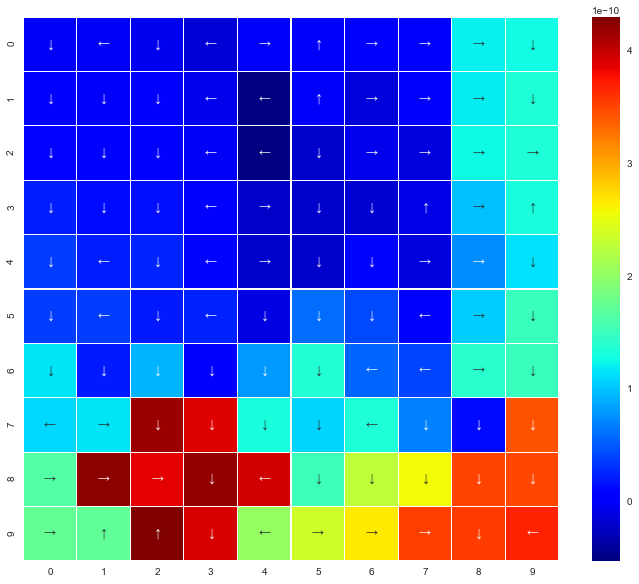

In [48]:
plt.figure(figsize = (12, 10))
# plt.title('Optimal State Value Heat Map for Extracted Reward Function 1', y = 1.08, size = 25)
sns.heatmap(temp_optimal_value_state, annot=optimal_value_action, fmt='',  linewidths=0.1, vmin=np.min(temp_optimal_value_state), vmax=np.max(temp_optimal_value_state), cmap='jet')
plt.show()

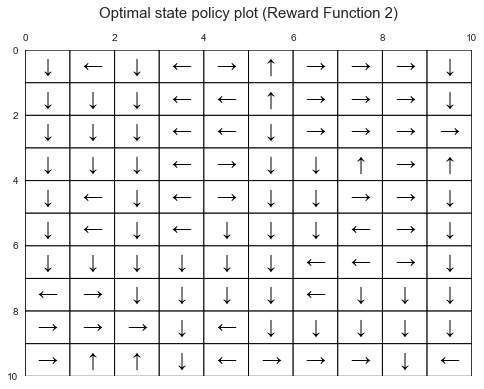

In [49]:
#Plotting the optimal value function
cmap = plt.cm.get_cmap(name = 'gray', lut = 1)
plt.figure(figsize = (8,6))
plt.pcolor(reward_function_2, cmap = cmap, edgecolor = 'k', linewidth = 1)
ax = plt.gca()

for i in range(10):
    for j in range(10):
        text = ax.text(j+0.5, i + 0.5, optimal_value_action[i][j],
                  ha = 'center',va = 'center', size = 20, color="k")
plt.title('Optimal state policy plot (Reward Function 2)', y = 1.08, size = 15)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.xaxis.set_label_position('top')

In [ ]:
temp_irl=lp_irl(100, 4, transition_probabilities, 0.8, lambda_max_2, 10, expert_pi_state)
temp_stuff = []
for v in temp_irl:
  temp_stuff.append(v)
print(temp_stuff)
# print(temp_irl)

In [ ]:
reward_function = reward_function_1.flatten('F')
print(reward_function)

In [ ]:
[expert_value_state,expert_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              reward_function_2.flatten('F'), estimation_epsilon, discount_factor)

acc=[]

for i in range(0, 501):
  lam=i/100
  irl_new=lp_irl(100, 4, transition_probabilities, 0.8, lam, 1, pi_state)
  [agent_value_state,agent_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              irl_new, estimation_epsilon, discount_factor)
  acc.append(comp(expert_pi_state,agent_pi_state))
  

In [ ]:
lam_list=[]
for i in range(0, 501):
  lam=i/100
  lam_list.append(lam)
print(lam_list)

plt.plot(lam_list,acc)

In [ ]:
print(np.argmax(acc))

In [ ]:
a=[]

nn_irl=lp_irl(100, 4, transition_probabilities, 0.8, lamb, 1, expert_pi_state)

a=nn_irl
a = np.array(a)
a = a.reshape(10, 10, order='F')

plt.figure(figsize = (20,20))

plt.imshow(a, cmap = 'jet')
ax = plt.gca()
plt.colorbar()
#plt.title('Reward Function 1 heatmap', y=1.1)
for y in range(10):
    for x in range(10):
        plt.text(x, y , '%.4f' % int(a[y, x]),
                 horizontalalignment='center',
                 verticalalignment='center', fontsize=15, color = 'w'
                 )
ax.xaxis.tick_top()
ax.set_xticks(np.arange(-0.5, 9, 1))
ax.set_yticks(np.arange(-0.5, 9, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.grid(color='w', linestyle='-', linewidth=1)

plt.text(0.5, 1.08, 'Heatmap for Reward Function 1',
         horizontalalignment='center',
         fontsize=40,
         transform = ax.transAxes)
ax.xaxis.set_label_position('top')

In [ ]:
[new_agent_value_state,new_agent_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              nn_irl, estimation_epsilon, discount_factor)

new_optimal_value_state = np.asarray(new_agent_value_state)
new_optimal_value_state = np.reshape(new_optimal_value_state, (rows,cols), order = 'F')


df = pd.DataFrame(new_optimal_value_state, columns = [i for i in range (cols)], index = [j for j in range(rows)])

#Plotting the optiaml value function
cmap = plt.cm.get_cmap(name = 'gray', lut = 1)
plt.figure(figsize = (8,6))
plt.pcolor(reward_function_2, cmap = cmap, edgecolor = 'k', linewidth = 1)
ax = plt.gca()

for i in range(10):
    for j in range(10):
        text = ax.text(j+0.5, i + 0.5, np.around(new_optimal_value_state[i][j], decimals = 3),
                  ha = 'center',va = 'center', size = 11, color="k")
plt.title('Optimal state value function plot (Reward Function 2)', y = 1.08, size = 15)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.xaxis.set_label_position('top')

#NEED TO PLOT OPTIMAL VALUE PROPERLY
#ASK HEATMAP
#GENERATE HEATMAP
plt.figure(figsize=(9,7))
plt.pcolor(new_optimal_value_state, cmap = 'hot', linewidth = 1, edgecolor = 'b')
ax = plt.gca()
ax.invert_yaxis()
plt.colorbar()
plt.title('Optimal value state heatmap (Reward Function 2)', y = 1.08, size = 15)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


In [ ]:
[new_agent_value_state,new_agent_pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              nn_irl, estimation_epsilon, discount_factor)

optimal_value_action = np.asarray(new_agent_pi_state)

#Convert char to arrow
for i in range(len(optimal_value_action)):
    action = optimal_value_action[i]
    if action == 'U':
        optimal_value_action[i] = '↑'
    elif action == 'D':
        optimal_value_action[i] = '↓'
    elif action == 'R':
        optimal_value_action[i] = '→'
    elif action == 'L':
        optimal_value_action[i] = '←'
        
optimal_value_action = np.reshape(optimal_value_action, (rows,cols), order = 'F')

df = pd.DataFrame(optimal_value_action, columns = [i for i in range (cols)], index = [j for j in range(rows)])

In [ ]:
qwqw=[2,3,0,-1,29,99,1]
np.argmax(qwqw)

In [ ]:
np.max(reward_function_1)

In [ ]:
np.zeros(10)